In [431]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

Read in and process dataset for photon flux.

In [588]:
data = pd.read_csv('./Blackhawk/t90_hardness_ratio/hardnessratios.tex', sep='\t')
data

,Time to Death,Mass,GBM NaI,GBM BGO,EdndE-8keV,EdndE-200keV,EdndE-1MeV,EdndE-40MeV,EdndE-200GeV
0,4.950000e+08,1.000000e+12,1.04,0.0959,7.670000e-07,1.530000e-10,1.530000e-13,6.140000e-15,1.230000e-12
1,4.950000e+08,1.000000e+12,1.04,0.0959,7.670000e-07,1.530000e-10,1.530000e-13,6.140000e-15,1.230000e-12
2,4.950000e+08,1.000000e+12,1.04,0.0959,7.670000e-07,1.530000e-10,1.530000e-13,6.140000e-15,1.230000e-12
3,4.950000e+08,1.000000e+12,1.04,0.0959,7.670000e-07,1.530000e-10,1.530000e-13,6.140000e-15,1.230000e-12
4,4.950000e+08,1.000000e+12,1.04,0.0959,7.670000e-07,1.530000e-10,1.530000e-13,6.140000e-15,1.230000e-12
...,...,...,...,...,...,...,...,...,...
807,2.340000e-15,1.760000e+04,37.80,2.5600,2.040000e-05,4.090000e-09,4.090000e-12,1.640000e-13,3.270000e-11
808,1.490000e-15,1.650000e+04,37.80,2.5600,2.040000e-05,4.090000e-09,4.090000e-12,1.640000e-13,3.270000e-11
809,1.060000e-15,1.520000e+04,37.80,2.5600,2.040000e-05,4.090000e-09,4.090000e-12,1.640000e-13,3.270000e-11
810,6.380000e-16,1.370000e+04,37.80,2.5600,2.040000e-05,4.090000e-09,4.090000e-12,1.640000e-13,3.270000e-11


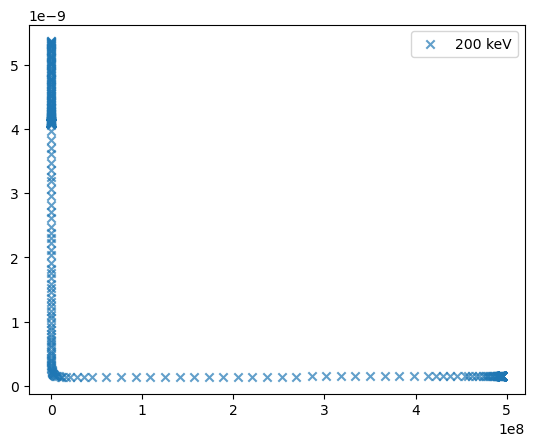

In [589]:
# Show the lightcurves

fig, ax = plt.subplots()

x = data['Time to Death']

#ax.scatter(x, data['EdndE-8keV'], label = '8 keV', marker='x', alpha=0.7)
ax.scatter(x, data['EdndE-200keV'], label = '200 keV', marker='x', alpha=0.7)
#ax.scatter(x, data['EdndE-1MeV'], label = '1 MeV', marker='x', alpha=0.7)
#ax.scatter(x, data['EdndE-40MeV'], label = '40 MeV', marker='x', alpha=0.7)
#ax.scatter(x, data['EdndE-200GeV'], label = '200 GeV', marker='x', alpha=0.7)

ax.legend()

#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.set_xlim(400, -1)

In [581]:
model_kev = Pipeline((
    ('pf', PolynomialFeatures(degree=2)),
    ('lr', LinearRegression())
))

kev = data[['Time to Death','EdndE-200keV']].loc[ data['Time to Death'] < 500].loc[data['Time to Death'] > .09]
kev['EdndE-200keV'] = np.log(kev['EdndE-200keV'])

X = data[['Time to Death']]
y = data['EdndE-200keV']

model_kev.fit(X,y)

Pipeline(steps=[('pf', PolynomialFeatures()), ('lr', LinearRegression())])

In [572]:
# Let's just focus on fitting the 200GeV and 200keV lines

# Create models
model_kev = Pipeline((
    ('pf', PolynomialFeatures()),
    ('lr', LinearRegression())
))
model_gev = Pipeline((
    ('pf', PolynomialFeatures()),
    ('lr', LinearRegression())
))

param_space = {'pf__degree':np.arange(1,6)}

# Prepare data
kev = data[['Time to Death','EdndE-200keV']].loc[ data['Time to Death'] < 500].loc[data['Time to Death'] > .09]
kev['EdndE-200keV'] = np.log(kev['EdndE-200keV'])
gev = data[['Time to Death','EdndE-200GeV']].loc[ data['Time to Death'] < 500].loc[data['Time to Death'] > .09]
gev['EdndE-200GeV'] = np.log(gev['EdndE-200GeV'])

search_kev = GridSearchCV(estimator = model_kev, param_grid = param_space, scoring = 'neg_mean_squared_error')
search_gev = GridSearchCV(estimator = model_gev, param_grid = param_space, scoring = 'neg_mean_squared_error')

search_kev.fit(X = kev[['Time to Death']], y = kev['EdndE-200keV'])
search_gev.fit(X = gev[['Time to Death']], y = gev['EdndE-200GeV'])

GridSearchCV(estimator=Pipeline(steps=(('pf', PolynomialFeatures()),
                                       ('lr', LinearRegression()))),
             param_grid={'pf__degree': array([1, 2, 3, 4, 5])},
             scoring='neg_mean_squared_error')

[0.  0.7]
-19.312885349785088


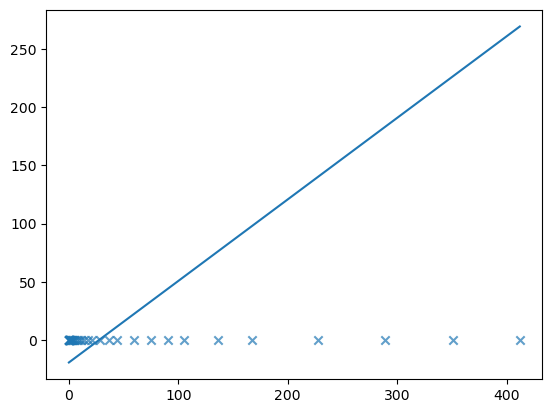

In [579]:
best_model = search_kev.best_estimator_

coefs = best_model['lr'].coef_
interc = best_model['lr'].intercept_

coefs[1]=.7

fig, ax = plt.subplots()

t = kev['Time to Death']
ax.scatter(t, np.exp(kev['EdndE-200keV']), label = 'data', marker='x', alpha=0.7)
model = interc
for i in range(len(coefs)-1):
    model += coefs[i+1]*t**(i+1)
ax.plot(t, model)
#ax.plot(t, np.exp(best_model.predict(kev[['Time to Death']])))

print(coefs)
print(interc)

[ 0.         -0.00283122]
-24.14126812903736


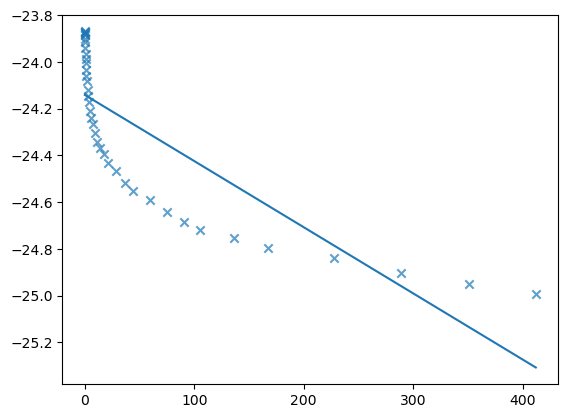

In [575]:
best_model = search_gev.best_estimator_

coefs = best_model['lr'].coef_
interc = best_model['lr'].intercept_

fig, ax = plt.subplots()

t = gev['Time to Death']
ax.scatter(t, gev['EdndE-200GeV'], label = 'data', marker='x', alpha=0.7)

ax.plot(t, best_model.predict(gev[['Time to Death']]))

print(coefs)
print(interc)

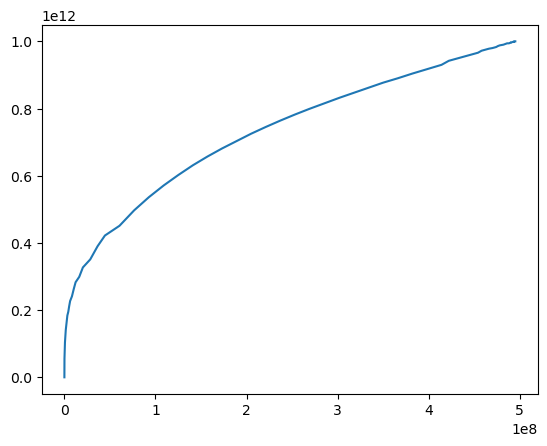

In [531]:
plt.plot(data['Time to Death'], data['Mass'])